## 対応のある2標本のt検定

同じ母集団から無作為抽出された2つの標本にてついて、標本平均が等しいかどうか？を検定する。

In [1]:
import os
import sys
sys.path.append("../../scripts")
import warnings
warnings.simplefilter('ignore')

# Libraries
import pandas as pd
import numpy as np
np.random.seed(111)

# scipy
from scipy import stats
# graph
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(111)

# scripts
import utils as u

In [2]:
# graph setting
u.graph_setting()

### データセット

In [3]:
# scikit-learnに用意されている、アヤメのデータセットを使う
from sklearn.datasets import load_iris
iris = load_iris()

# irisのデータセットは、辞書型で格納されているので、扱いやすいようにpandasのデータフレームに変換する。
# 各特徴データ
df = pd.DataFrame(iris.data, columns=iris.feature_names)
# ラベル, 種類のデータ。各数値ラベルを名前に置き換えて加える。
df["target"] = [iris.target_names[t] for t in iris.target]

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
# データセットの準備
# 'setosa'のデータをランダマイズ
df_setosa = df[df["target"]=="setosa"].sample(frac=1).reset_index(drop=True)

# sampling values
values = df_setosa["sepal length (cm)"].values

# dataset 1, and 2 sample
values1 = values[:int(len(values)/2)]
values2 = values[int(len(values)/2):]

values1, values2

(array([5.5, 4.8, 5.4, 4.9, 5.4, 4.7, 5.1, 5.1, 5.1, 5. , 5.7, 5.5, 4.9,
        4.4, 5.3, 4.6, 5. , 4.8, 5. , 5.1, 5. , 5.2, 5.2, 4.3, 5. ]),
 array([4.6, 4.9, 5.4, 4.4, 4.8, 5.1, 4.4, 5.8, 5.2, 4.8, 4.9, 5.4, 4.8,
        5.1, 5. , 5. , 5.7, 4.7, 4.5, 5.1, 4.6, 4.6, 5. , 5.1, 5.4]))

### 問題設定

- ある花畑での'setosa'の'sepal length(cm)'を計測する。<br>
- 取得したデータはある2区画のデータとし25本ずつ抽出したものとする。<br>
- それぞれの区画の平均値に差があるといえるか？を統計的に検定する。<br>
->データセットは元のirisデータをランダムに2分割したものを、2つの区画のデータと仮定して取り扱う。<br>

帰無仮説：'setosa'の'sepal length'の平均値は変わらない。<br>
対立仮説：2つの区画の平均値が異なる。<br>
優位水準α=5%(両側)とし判断する。<br>

### データをグラフ確認

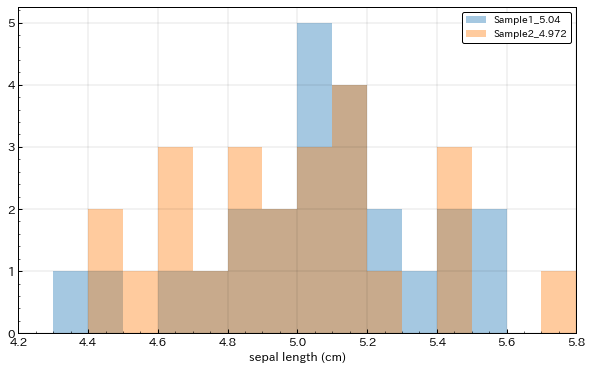

In [9]:
# distplot
fig, ax = plt.subplots(figsize=(10,6))

sns.distplot(values1, bins=np.arange(np.min(values1)-0.1, np.max(values1)+0.1, 0.1), kde=False, ax=ax, label=f"Sample1_{np.mean(values1)}")
sns.distplot(values2, bins=np.arange(np.min(values2)-0.1, np.max(values2)+0.1, 0.1), kde=False, ax=ax, label=f"Sample2_{np.mean(values2)}")
ax.set_xlabel("sepal length (cm)")
ax.set_xlim([np.min(values1)-0.1, np.max(values1)+0.1])
ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


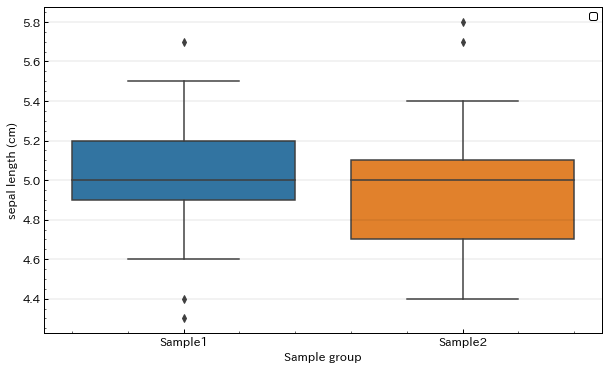

In [28]:
# box plot
fig, ax = plt.subplots(figsize=(10,6))

data = pd.concat([
       pd.DataFrame({"Sample":["Sample1" for i in range(len(values1))],
                     "Values":values1}),
       pd.DataFrame({"Sample":["Sample2" for i in range(len(values2))],
                     "Values":values2})
       ]).reset_index(drop=True)

sns.boxplot(data=data, x="Sample", y="Values")
ax.set_xlabel("Sample group")
ax.set_ylabel("sepal length (cm)")
ax.legend()

### (1)統計量を求めながらt値を計算する

In [29]:
# Function
def calc_tvalue(values1:list, values2:list)->float:
    '''
    tを計算する

    Args
        values1 (list) : 標本1の計算対象の1次元リスト。numpy.arrayやpandas.Seriesも可
        values1 (list) : 標本1の計算対象の1次元リスト。numpy.arrayやpandas.Seriesも可

    Return
        t : 計算されたt値を返す。
    '''

    # calculate difference
    d = np.array(values1) - np.array(values2)

    # calc mean
    m_d = np.mean(d)
    # calc std, 不偏標本標準偏差を使う
    s_d = np.std(d, ddof=1)
    # dataset count
    n = len(d)

    # calc standard error
    se = s_d / np.sqrt(n)

    # t value
    t = m_d / se

    # print each value
    print(f"Average difference : {m_d}")
    print(f"Standard error : {se}")
    print(f"t value : {t}")


    return t

In [30]:
# calculate t value
t = calc_tvalue(values1=values1, values2=values2)
t

Average difference : 0.068
Standard error : 0.10011992808627061
t value : 0.6791854658685558


0.6791854658685558

In [17]:
# 両側信頼係数のt値を求める。

# 自由度
d = len(values1) - 1
# 片側優位水準
alpha = 0.025

# scipy.statsを使って計算する。
t_thre = stats.t.ppf(1 - alpha/2, d)
print(t_thre)

2.390949315129389


### 判定
- t値は0.679で、優位水準5%の片側2.5%点の値2.39より小さい。よって帰無仮説は棄却されない。<br>
-> 差は無い

### (2) scipy.stats.ttest_rel()関数を使って計算する。

In [18]:
t_value, p_value = stats.ttest_rel(a=values1, b=values2, alternative="two-sided", )
t_value, p_value

(0.6791854658685557, 0.5035184002287219)

### 判定
- p値は0.504と優位水準5%より大きい。よって帰無仮説は棄却されない。<br>
-> 差は無い

### グラフ確認
t分布表を見て、値の関係をイメージする。

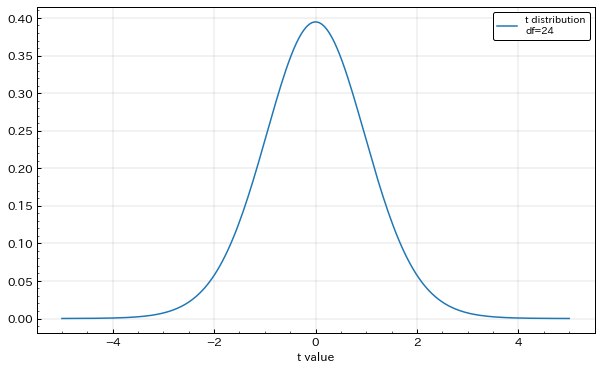

In [26]:
# t分布サンプリング
t_range = np.linspace(-5,5,200)
t_value_ar = []
for i in t_range:
    t_value_ar.append(stats.t.pdf(x=i, df=len(values1)-1))

# plot
plt.figure(figsize=(10,6))
plt.plot(t_range, t_value_ar, label="t distribution\ndf={}".format(len(values1)-1))
plt.xlabel("t value")
plt.legend()